# Умножаем матрички

Задача №1 для всех, которую нужно сделать до 15 октября — написать блочное умножение матриц

---

Мне нужно четыре графика:
1) время умножения матриц от размера матриц для наивной однопоточной реализации
2) время умножения матриц от размера матриц для блочного умножения в 1 поток
3) время умножения матриц от количества тредов для не-блочного разделения задач по тредам (например, по строкам / столбцам)
4) время умножения матриц от количества тредов для блочной реализации

Размер матриц для (3,4) давайте возьмём 20 MB.

Графики для (2,4) должны получиться как можно лучше.

Если в группе будет желание, можете написать бенчмарки коллективно и устроить небольшое соревнование на одних и тех же тестах.

Писать можете на чистом С, GNU диалекте или на C++. Ограничение — не пишите на "старом" С++, используйте средства С++11. И не используйте OpenMP, будьте добры сами запускать треды

---

Вопросы к 1 задаче:
- что такое тред
- зачем нужен кэш
- как устроен кэш, cache line, invalidation
- false sharing
- почему блочный алгоритм быстрее (= причём тут кэш)
- смысл методов c / c++ в программе

## Почему время замеряется так, как замеряется

Вопрос 5 к задаче подразумевает, что блочный алгоритм должен быть быстрее)))

Поэтому давайте максимально читерить:
* Не учитывать в замерах время, потраченное на работу с памятью (выделение / очистка)
* Не учитывать время, потраченное на создание потоков (будем запускать через кондвар)
* Не учитывать время, потраченное на удаление потоков из памяти

А если не читерить?)
* Просто хранение второй матрицы в транспонированном виде уже дает огромный прирост к скорости.
* Работа с памятью и потоками - сверхтрудоёмкие операции и они сводят на нет все плюшки

(ну и в задании просили замерить время умножения, так что считаю что это ок)

---

# Делаем замеры

## Prelude

Кратенько о том, как это работает

1. Есть програмка на Си
    * Програмка умеет генерировать случайные матрички и умножать их
    * Програмка замеряет ТОЛЬКО время потраченное на само умножение (опуская выделение памяти и прочее)
    * После умножения, програмка пишет на стандартный поток вывода время (в попугаях)
    * Способ умножения определяется на этапе компиляции (путем линковки с одним из модулей)
2. Есть runner.sh
    * Runner запускает програмку на Си с одинаковыми параметрами k раз
    * Время работы програмки зависит от:
        - Загруженности оперативной памяти
        - Загруженности процессора
        - Чиселок в матрицах
        - Фазы луны
        - Меркурия в ретрограде
    * Чтоб это победить, буду проводить k измерений и брать моду
    * Результаты всех k измерений дописывает в measures.csv

Готовим runner

In [1]:
%%writefile runner.sh
#!/bin/bash

N=$1
M=$2
K=$3

nthreads=$4

block_nrows=$5
block_ncols=$6

run_n_times=$7

calculator=$8

# echo '' > measures.csv

for i in $(seq $run_n_times)
{
    echo -en "\r$N: $i/$run_n_times starting..."
    echo -e "$calculator,$N-$M-$K,$block_nrows-$block_ncols,$nthreads,$(./a.out $N $M $K $nthreads $block_nrows $block_ncols)" >> measures.csv
}
echo ''

Overwriting runner.sh


In [2]:
!chmod +x runner.sh
!ls

Makefile  main.c.backup  measures.csv.backup  vgcore.441114
a.out	  main.ipynb	 runner.sh	      vgcore.441182
main.c	  measures.csv	 src


In [3]:
# Готовим measures.csv
!echo 'calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks' > measures.csv

Максимальный размер матрицы будем брать:

$2048 * 5120 * sizeof(uint16\_t) = 1024 * 1024 * 5 * 2 * 2 = 20M$

## Native multiplication

In [4]:
!make native

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 8 8 8 0 0 0 5 'native,no'
!./runner.sh 16 16 16 0 0 0 5 'native,no'
!./runner.sh 32 32 32 0 0 0 5 'native,no'
!./runner.sh 64 64 64 0 0 0 5 'native,no'
!./runner.sh 128 128 128 0 0 0 5 'native,no'
!./runner.sh 256 256 256 0 0 0 5 'native,no'
!./runner.sh 512 512 512 0 0 0 5 'native,no'
!./runner.sh 1024 1024 1024 0 0 0 5 'native,no'
# !./runner.sh 2048 5120 2048 0 0 0 5 'native,no' # -- too slow

!tail -n 5 measures.csv

gcc -std=gnu11 -O0  -c main.c
gcc -std=gnu11 -O0  -c src/native.c -o mul.o
gcc -std=gnu11 -O0  main.o mul.o -o a.out && rm -rf *.o
8: 5/5 starting...
16: 5/5 starting...
32: 5/5 starting...
64: 5/5 starting...
128: 5/5 starting...
256: 5/5 starting...
512: 5/5 starting...
1024: 5/5 starting...
native,no,1024-1024-1024,0-0,0,12953543
native,no,1024-1024-1024,0-0,0,13507139
native,no,1024-1024-1024,0-0,0,13470958
native,no,1024-1024-1024,0-0,0,12517843
native,no,1024-1024-1024,0-0,0,14337590


In [5]:
!make APPEND_FLAGS='-DTRANSPOSED' native

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 8 8 8 0 0 0 5 'native,yes'
!./runner.sh 16 16 16 0 0 0 5 'native,yes'
!./runner.sh 32 32 32 0 0 0 5 'native,yes'
!./runner.sh 64 64 64 0 0 0 5 'native,yes'
!./runner.sh 128 128 128 0 0 0 5 'native,yes'
!./runner.sh 256 256 256 0 0 0 5 'native,yes'
!./runner.sh 512 512 512 0 0 0 5 'native,yes'
!./runner.sh 1024 1024 1024 0 0 0 5 'native,yes'
# !./runner.sh 2048 5120 2048 0 0 0 5 'native,yes' # -- too slow

!tail -n 5 measures.csv

gcc -std=gnu11 -O0 -DTRANSPOSED -c main.c
gcc -std=gnu11 -O0 -DTRANSPOSED -c src/native.c -o mul.o
gcc -std=gnu11 -O0 -DTRANSPOSED main.o mul.o -o a.out && rm -rf *.o
8: 5/5 starting...
16: 5/5 starting...
32: 5/5 starting...
64: 5/5 starting...
128: 5/5 starting...
256: 5/5 starting...
512: 5/5 starting...
1024: 5/5 starting...
native,yes,1024-1024-1024,0-0,0,4882325
native,yes,1024-1024-1024,0-0,0,5070888
native,yes,1024-1024-1024,0-0,0,4823981
native,yes,1024-1024-1024,0-0,0,4713579
native,yes,1024-1024-1024,0-0,0,4742100


## Block multiplication

In [6]:
!make block

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 8 8 8 0 2 2 5 'block,no'
!./runner.sh 16 16 16 0 4 4 5 'block,no'
!./runner.sh 32 32 32 0 8 8 5 'block,no'
!./runner.sh 64 64 64 0 16 16 5 'block,no'
!./runner.sh 128 128 128 0 32 32 5 'block,no'
!./runner.sh 256 256 256 0 32 32 5 'block,no'
!./runner.sh 512 512 512 0 32 32 5 'block,no'
!./runner.sh 1024 1024 1024 0 64 64 5 'block,no'
# !./runner.sh 2048 5120 2048 0 0 0 10 'block,no' # -- too slow

!tail -n 5 measures.csv

gcc -std=gnu11 -O0  -c main.c
gcc -std=gnu11 -O0  -c src/block.c -o mul.o
gcc -std=gnu11 -O0  main.o mul.o -o a.out && rm -rf *.o
8: 5/5 starting...
16: 5/5 starting...
32: 5/5 starting...
64: 5/5 starting...
128: 5/5 starting...
256: 5/5 starting...
512: 5/5 starting...
1024: 5/5 starting...
block,no,1024-1024-1024,64-64,0,7940231
block,no,1024-1024-1024,64-64,0,8042527
block,no,1024-1024-1024,64-64,0,8130120
block,no,1024-1024-1024,64-64,0,8019771
block,no,1024-1024-1024,64-64,0,8106365


In [7]:
!make APPEND_FLAGS='-DTRANSPOSED' block

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 8 8 8 0 2 2 5 'block, yes'
!./runner.sh 16 16 16 0 4 4 5 'block, yes'
!./runner.sh 32 32 32 0 8 8 5 'block, yes'
!./runner.sh 64 64 64 0 16 16 5 'block, yes'
!./runner.sh 128 128 128 0 32 32 5 'block, yes'
!./runner.sh 256 256 256 0 32 32 5 'block, yes'
!./runner.sh 512 512 512 0 32 32 5 'block, yes'
!./runner.sh 1024 1024 1024 0 64 64 5 'block, yes'
# !./runner.sh 2048 5120 2048 0 0 0 10 'native, yes' # -- too slow

!tail -n 5 measures.csv

gcc -std=gnu11 -O0 -DTRANSPOSED -c main.c
gcc -std=gnu11 -O0 -DTRANSPOSED -c src/block.c -o mul.o
gcc -std=gnu11 -O0 -DTRANSPOSED main.o mul.o -o a.out && rm -rf *.o
8: 5/5 starting...
16: 5/5 starting...
32: 5/5 starting...
64: 5/5 starting...
128: 5/5 starting...
256: 5/5 starting...
512: 5/5 starting...
1024: 5/5 starting...
block, yes,1024-1024-1024,64-64,0,4645266
block, yes,1024-1024-1024,64-64,0,4933353
block, yes,1024-1024-1024,64-64,0,4955850
block, yes,1024-1024-1024,64-64,0,4915380
block, yes,1024-1024-1024,64-64,0,4919779


## Native multithreading multiplication

In [1]:
!make native_m

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 2048 5120 2048 2 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 3 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 4 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 5 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 6 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 8 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 10 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 12 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 14 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 16 0 0 5 'native_m,no'
!./runner.sh 2048 5120 2048 32 0 0 5 'native_m,no'

!tail -n 5 measures.csv

gcc -std=gnu11 -O0  -c main.c
gcc -std=gnu11 -O0  -c src/native_m.c -o mul.o
gcc -std=gnu11 -O0  main.o mul.o -o a.out && rm -rf *.o
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
native_m,no,2048-5120-2048,0-0,32,1432978304
native_m,no,2048-5120-2048,0-0,32,1434466236
native_m,no,2048-5120-2048,0-0,32,1422764140
native_m,no,2048-5120-2048,0-0,32,1436922607
native_m,no,2048-5120-2048,0-0,32,1438590622


In [2]:
!make APPEND_FLAGS='-DTRANSPOSED' native_m

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 2048 5120 2048 2 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 3 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 4 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 5 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 6 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 8 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 10 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 12 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 14 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 16 0 0 5 'native_m,yes'
!./runner.sh 2048 5120 2048 32 0 0 5 'native_m,yes'

!tail -n 5 measures.csv

gcc -std=gnu11 -O0 -DTRANSPOSED -c main.c
gcc -std=gnu11 -O0 -DTRANSPOSED -c src/native_m.c -o mul.o
gcc -std=gnu11 -O0 -DTRANSPOSED main.o mul.o -o a.out && rm -rf *.o
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
native_m,yes,2048-5120-2048,0-0,32,350916002
native_m,yes,2048-5120-2048,0-0,32,350894251
native_m,yes,2048-5120-2048,0-0,32,351144666
native_m,yes,2048-5120-2048,0-0,32,350146362
native_m,yes,2048-5120-2048,0-0,32,351151412


## Block multithreading multiplication

Давайте (для простоты) при разбиении на N блоков запускать N тредов

In [3]:
!make APPEND_FLAGS='-DTRANSPOSED' block_m

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 2048 5120 2048 2 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 3 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 4 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 5 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 6 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 8 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 10 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 14 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 16 64 64 5 'block_m,yes'
!./runner.sh 2048 5120 2048 32 64 64 5 'block_m,yes'

!tail -n 5 measures.csv

gcc -std=gnu11 -O0 -DTRANSPOSED -c main.c
gcc -std=gnu11 -O0 -DTRANSPOSED -c src/block_m.c -o mul.o
gcc -std=gnu11 -O0 -DTRANSPOSED main.o mul.o -o a.out && rm -rf *.o
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
block_m,yes,2048-5120-2048,64-64,32,347012427
block_m,yes,2048-5120-2048,64-64,32,345620821
block_m,yes,2048-5120-2048,64-64,32,349118561
block_m,yes,2048-5120-2048,64-64,32,347174097
block_m,yes,2048-5120-2048,64-64,32,346776020


In [4]:
# Ещё один тест (как я думаю будет быстрее)

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 2048 5120 2048 10 64 128 5 'block_m_f,yes'
!./runner.sh 2048 5120 2048 10 128 256 5 'block_m_f,yes'
!./runner.sh 2048 5120 2048 10 256 512 5 'block_m_f,yes'

# Больше потоков -> больше вредной работы
# У меня 4 ядра, 8 потоков

!tail -n 5 measures.csv

2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
block_m_f,yes,2048-5120-2048,256-512,10,370728780
block_m_f,yes,2048-5120-2048,256-512,10,441520470
block_m_f,yes,2048-5120-2048,256-512,10,424660886
block_m_f,yes,2048-5120-2048,256-512,10,441689865
block_m_f,yes,2048-5120-2048,256-512,10,451594447


In [5]:
# И последний разик)

# N, M, K, nthreads, block_nrows, block_ncols, run_n_times, calculator
!./runner.sh 2048 5120 2048 10 8 16 5 'block_m_f, yes'
!./runner.sh 2048 5120 2048 10 16 32 5 'block_m_f, yes'
!./runner.sh 2048 5120 2048 10 32 64 5 'block_m_f, yes'

!tail -n 5 measures.csv

2048: 5/5 starting...
2048: 5/5 starting...
2048: 5/5 starting...
block_m_f, yes,2048-5120-2048,32-64,10,365247755
block_m_f, yes,2048-5120-2048,32-64,10,364722503
block_m_f, yes,2048-5120-2048,32-64,10,366293854
block_m_f, yes,2048-5120-2048,32-64,10,365527026
block_m_f, yes,2048-5120-2048,32-64,10,363471654


# Обрабатываем результаты

> (за кадром удаляем пробелы)

In [23]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
df = pd.read_csv('measures.csv')
df.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
0,native,no,8-8-8,0-0,0,7
1,native,no,8-8-8,0-0,0,12
2,native,no,8-8-8,0-0,0,7
3,native,no,8-8-8,0-0,0,7
4,native,no,8-8-8,0-0,0,7


In [25]:
df['calculator'].unique()

array(['native', 'block', 'native_m', 'block_m', 'block_m_f'],
      dtype=object)

## Время умножения матриц от размера матриц для наивной однопоточной реализации

In [32]:
df_native = df.loc[df['calculator'] == 'native'].copy()

df_native.head(5)

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
0,native,no,8-8-8,0-0,0,7
1,native,no,8-8-8,0-0,0,12
2,native,no,8-8-8,0-0,0,7
3,native,no,8-8-8,0-0,0,7
4,native,no,8-8-8,0-0,0,7


In [33]:
df_native['size'] = df_native['N_M_K'].apply(lambda x: x.split('-')[0]).astype(int)

df_native.head(10)

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks,size
0,native,no,8-8-8,0-0,0,7,8
1,native,no,8-8-8,0-0,0,12,8
2,native,no,8-8-8,0-0,0,7,8
3,native,no,8-8-8,0-0,0,7,8
4,native,no,8-8-8,0-0,0,7,8
5,native,no,16-16-16,0-0,0,58,16
6,native,no,16-16-16,0-0,0,57,16
7,native,no,16-16-16,0-0,0,58,16
8,native,no,16-16-16,0-0,0,57,16
9,native,no,16-16-16,0-0,0,59,16


In [34]:
df_native = df_native.groupby(['transposed', 'size'])['clocks'].mean().reset_index()

df_native.head(10)

,transposed,size,clocks
0,no,8,8.0
1,no,16,57.8
2,no,32,201.8
3,no,64,1485.0
4,no,128,12974.2
5,no,256,116786.8
6,no,512,1137578.0
7,no,1024,13357414.6
8,yes,8,14.0
9,yes,16,74.0


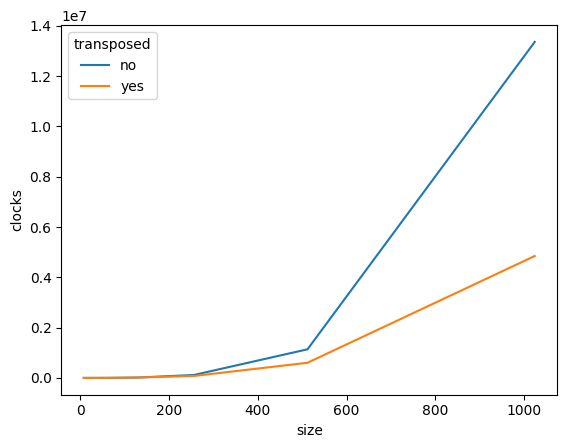

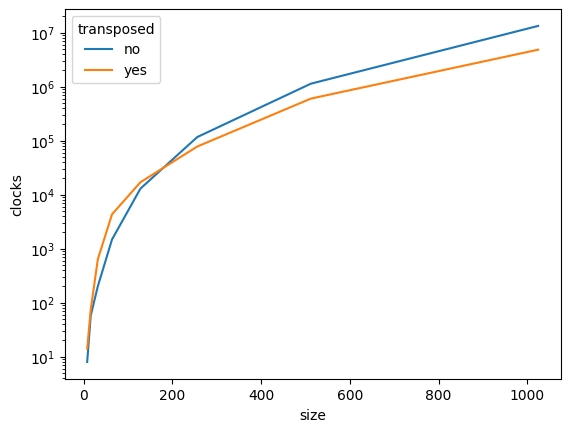

In [40]:
sns.lineplot(data=df_native, x='size', y='clocks', hue='transposed');
plt.show();
sns.lineplot(data=df_native, x='size', y='clocks', hue='transposed');
plt.yscale('log');
plt.show();

Мораль - храните вторую матрицу в транспонированном виде

## Время умножения матриц от размера матриц для блочного умножения в 1 поток

In [41]:
df_block = df.loc[df['calculator'] == 'block'].copy()

df_block.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
80,block,no,8-8-8,2-2,0,11
81,block,no,8-8-8,2-2,0,12
82,block,no,8-8-8,2-2,0,11
83,block,no,8-8-8,2-2,0,11
84,block,no,8-8-8,2-2,0,12


In [42]:
df_block['size'] = df_block['N_M_K'].apply(lambda x: x.split('-')[0]).astype(int)

df_block.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks,size
80,block,no,8-8-8,2-2,0,11,8
81,block,no,8-8-8,2-2,0,12,8
82,block,no,8-8-8,2-2,0,11,8
83,block,no,8-8-8,2-2,0,11,8
84,block,no,8-8-8,2-2,0,12,8


In [43]:
df_block = df_block.groupby(['transposed', 'size'])['clocks'].mean().reset_index()

df_block.head(10)

,transposed,size,clocks
0,yes,8,12.4
1,yes,16,68.6
2,yes,32,411.8
3,yes,64,3695.6
4,yes,128,16046.2
5,yes,256,77487.6
6,yes,512,587767.2
7,yes,1024,4873925.6
8,no,8,11.4
9,no,16,70.2


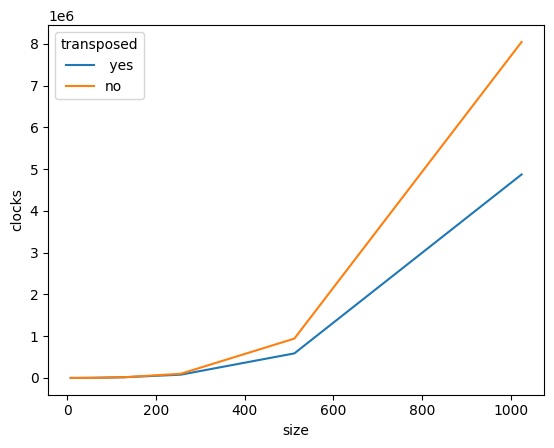

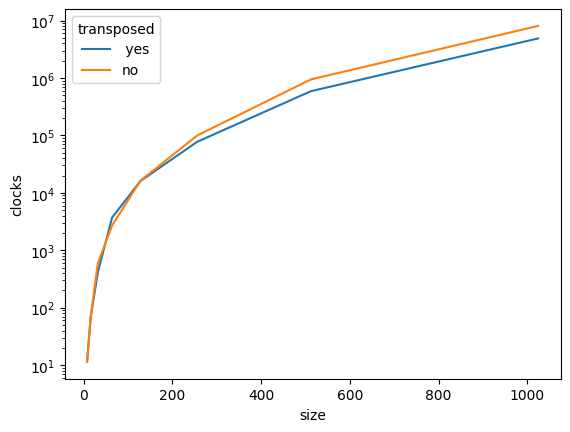

In [44]:
sns.lineplot(data=df_block, x='size', y='clocks', hue='transposed');
plt.show();
sns.lineplot(data=df_block, x='size', y='clocks', hue='transposed');
plt.yscale('log');
plt.show();

Интересно, но ничего не понятно, давайте построим хороший график

In [55]:
df_native_block = df.loc[(df['calculator'] == 'native') | (df['calculator'] == 'block')].copy()

df_native_block.sample(5)

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
29,native,no,256-256-256,0-0,0,111598
41,native,yes,8-8-8,0-0,0,11
96,block,no,64-64-64,16-16,0,2509
11,native,no,32-32-32,0-0,0,196
8,native,no,16-16-16,0-0,0,57


In [56]:
df_native_block['size'] = df_native_block['N_M_K'].apply(lambda x: x.split('-')[0]).astype(int)

df_native_block.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks,size
0,native,no,8-8-8,0-0,0,7,8
1,native,no,8-8-8,0-0,0,12,8
2,native,no,8-8-8,0-0,0,7,8
3,native,no,8-8-8,0-0,0,7,8
4,native,no,8-8-8,0-0,0,7,8


In [57]:
df_native_block = df_native_block.groupby(['transposed', 'size', 'calculator'])['clocks'].mean().reset_index()

df_native_block.head(10)

,transposed,size,calculator,clocks
0,yes,8,block,12.4
1,yes,16,block,68.6
2,yes,32,block,411.8
3,yes,64,block,3695.6
4,yes,128,block,16046.2
5,yes,256,block,77487.6
6,yes,512,block,587767.2
7,yes,1024,block,4873925.6
8,no,8,block,11.4
9,no,8,native,8.0


In [64]:
df_native_block['hue'] = df_native_block['calculator'] + '_' + df_native_block['transposed']

df_native_block.head()

,transposed,size,calculator,clocks,hue
0,yes,8,block,12.4,block_ yes
1,yes,16,block,68.6,block_ yes
2,yes,32,block,411.8,block_ yes
3,yes,64,block,3695.6,block_ yes
4,yes,128,block,16046.2,block_ yes


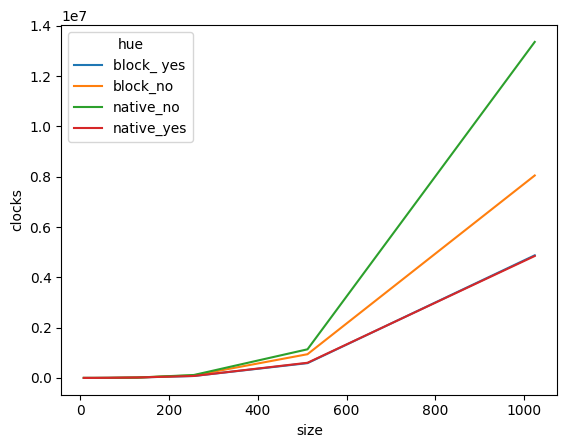

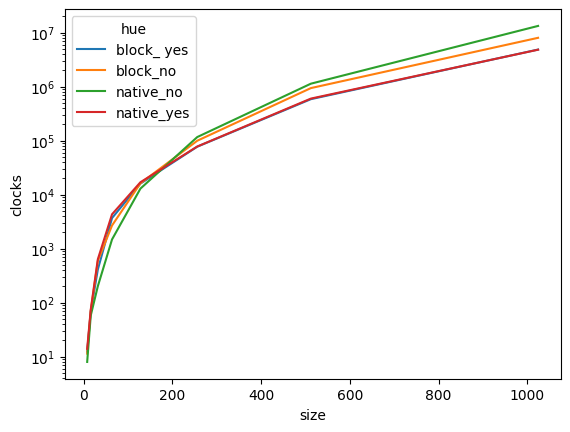

In [66]:
sns.lineplot(data=df_native_block, x='size', y='clocks', hue='hue');
plt.show();
sns.lineplot(data=df_native_block, x='size', y='clocks', hue='hue');
plt.yscale('log');
plt.show();

Синяя (block + transformed) идет позади красной (native + transformed)

Нетранспонированные версии показывают, что я не умею в оптимизацию)

## Время умножения матриц от количества тредов для не-блочного разделения задач по тредам (например, по строкам / столбцам)

In [67]:
df_native_m = df.loc[df['calculator'] == 'native_m'].copy()

df_native_m.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
160,native_m,no,2048-5120-2048,0-0,2,1194233000
161,native_m,no,2048-5120-2048,0-0,2,1071852105
162,native_m,no,2048-5120-2048,0-0,2,981622121
163,native_m,no,2048-5120-2048,0-0,2,976946649
164,native_m,no,2048-5120-2048,0-0,2,1000173997


In [68]:
df_native_m = df_native_m.groupby(['transposed', 'nthreads'])['clocks'].mean().reset_index()

df_native_m.head()

,transposed,nthreads,clocks
0,no,2,1.044966e+09
1,no,3,9.687381e+08
2,no,4,9.964105e+08
3,no,5,9.941943e+08
4,no,6,1.032252e+09


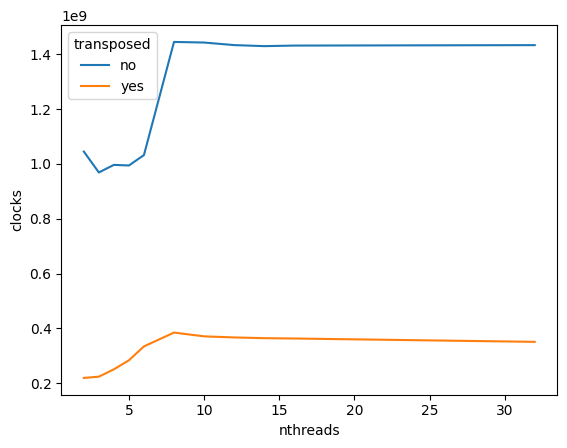

In [75]:
sns.lineplot(data=df_native_m, x='nthreads', y='clocks', hue='transposed');

Вот тут я на самом деле сам удивлен

Я ожидал максимум производительности около кол-ва потоков (4 ядра, 8 потоков $\rightarrow$ 8-10). 

А он попадает в 4 (почти ровно)

## Время умножения матриц от количества тредов для блочной реализации

In [70]:
df_block_m = df.loc[df['calculator'] == 'block_m'].copy()

df_block_m.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
270,block_m,yes,2048-5120-2048,64-64,2,206518948
271,block_m,yes,2048-5120-2048,64-64,2,206946626
272,block_m,yes,2048-5120-2048,64-64,2,207238834
273,block_m,yes,2048-5120-2048,64-64,2,207760957
274,block_m,yes,2048-5120-2048,64-64,2,207450900


In [71]:
df_block_m = df_block_m.groupby(['transposed', 'nthreads'])['clocks'].mean().reset_index()

df_block_m.head()

,transposed,nthreads,clocks
0,yes,2,207183253.0
1,yes,3,212097861.8
2,yes,4,234926270.8
3,yes,5,283565643.4
4,yes,6,329840706.4


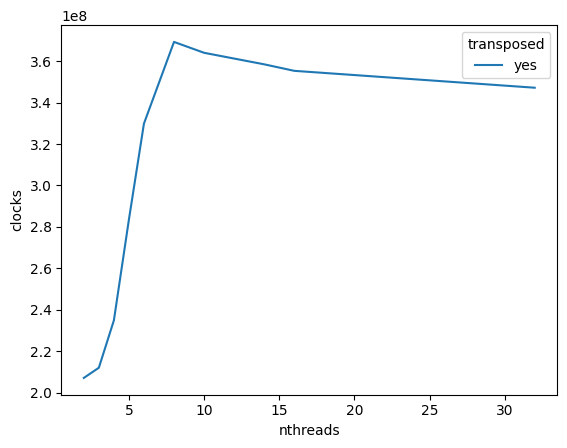

In [73]:
sns.lineplot(data=df_block_m, x='nthreads', y='clocks', hue='transposed');

## Сравнение скоростей блочной и нативной реализаций

In [84]:
df_block_m_native_m = df.loc[(df['calculator'] == 'native_m') | (df['calculator'] == 'block_m')].copy()

df_block_m_native_m.head()

,calculator,transposed,N_M_K,bnr_bnc,nthreads,clocks
160,native_m,no,2048-5120-2048,0-0,2,1194233000
161,native_m,no,2048-5120-2048,0-0,2,1071852105
162,native_m,no,2048-5120-2048,0-0,2,981622121
163,native_m,no,2048-5120-2048,0-0,2,976946649
164,native_m,no,2048-5120-2048,0-0,2,1000173997


In [85]:
df_block_m_native_m = df_block_m_native_m.groupby(['transposed', 'nthreads', 'calculator'])['clocks'].mean().reset_index()
df_block_m_native_m['hue'] = df_block_m_native_m['calculator'] + '_' + df_block_m_native_m['transposed']

df_block_m_native_m.head()

,transposed,nthreads,calculator,clocks,hue
0,no,2,native_m,1.044966e+09,native_m_no
1,no,3,native_m,9.687381e+08,native_m_no
2,no,4,native_m,9.964105e+08,native_m_no
3,no,5,native_m,9.941943e+08,native_m_no
4,no,6,native_m,1.032252e+09,native_m_no


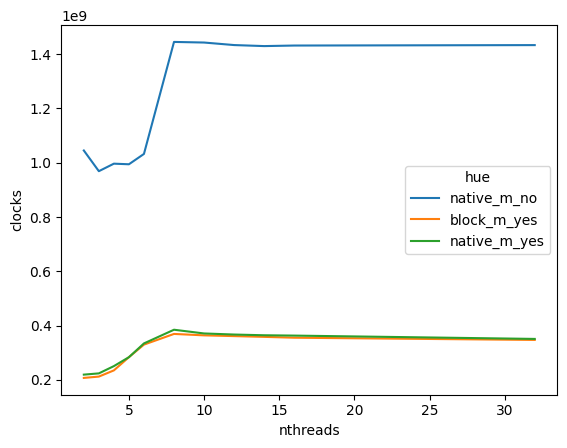

In [86]:
sns.lineplot(data=df_block_m_native_m, x='nthreads', y='clocks', hue='hue');

Ну и снова блочная и нативная реализация почти не отличаются

## ~ Выводы

Я ожидал, что блочная реализаци будет выигрывать у нативной для НЕТРАНСПОНИРОВАННОГО случая

По сути у них только отличаются асимптотики